In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError
from sklearn.metrics import log_loss as log_loss

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from evidential import *
from util import *


In [15]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [16]:
def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [17]:
# Set up device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda device NVIDIA TITAN V


In [18]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
bs_list = [128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 30
load_values = True
save_values = False

#Data constants
shapes = [2, 4]
scales = [3, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
grid_rmax = grid_data["x1"].max()

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = label_maker(test_data["class"], 2)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [19]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

In [20]:
epochs = 100 #Affects annealation coefficient
lr = 0.001

test_dfs = [0]*len(n_data)
grid_dfs = [0]*len(n_data)

for i in range(len(n_data)):
    if load_values == False:
        logloss_min = 1
        test_dfs[i] = pd.read_csv(f"../data/{testfile}.csv")
        grid_dfs[i] = pd.read_csv(f"../data/{gridfile}.csv")
        for j in tqdm(range(20)):
            val_df = pd.read_csv(f"../data/{valfile}.csv")
            n_train = n_data[i]
            batchsize = bs_list[i]

            model = SequentialNet(L=200, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)

            optimizer = optim.Adam(model.parameters(), lr=lr)
            train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
            training_results = train_evidential_classifier(model, train_dataset, 
                                    val_dataset, batchsize=batchsize, epochs = epochs, 
                                    device = device, optimizer = optimizer, early_stopping=patience)
            
            probs_val, uncertainties_val, beliefs_val = predict_evidential_classifier(model, val_dataset, 2, 100, device)
            preds_val = torch.argmax(probs_val, dim=-1).flatten()
            val_df["Prediction"] = preds_val
            val_df["Est_prob_blue"] = probs_val[:,1] #Get probability score for blue

            ll = log_loss(val_df["class"], val_df["Est_prob_blue"])
            preds = torch.Tensor(val_df["Est_prob_blue"])
            target = torch.Tensor(val_df["class"])
            bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
            ece = bce_l1(preds, target).item()
            print(f"n_train = {n_data[i]}, logloss={ll}, ECE= {ece}, best value: {logloss_min}")

            if ll < logloss_min:
                print(f"New best values: n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")
                logloss_min = ll

                probs_test, uncertainties_test, beliefs_test = predict_evidential_classifier(model, test_dataset, 2, 100, device)
                preds_test = torch.argmax(probs_test, dim=-1).flatten()
                test_dfs[i]["Prediction"] = preds_test
                test_dfs[i]["Est_prob_blue"] = probs_test[:,1] #Get probability score for blue
                test_dfs[i]["Uncertainty"] = uncertainties_test[:,1]
                test_dfs[i]["Std_prob_blue"] = uncertainties_test[:,1]/2
                test_dfs[i]["Beliefs"] = beliefs_test[:,1]

                probs_grid, uncertainties_grid, beliefs_grid = predict_evidential_classifier(model, grid_dataset, 2, 100, device)
                preds_grid = torch.argmax(probs_grid, dim=-1).flatten()
                grid_dfs[i]["Prediction"] = preds_grid
                grid_dfs[i]["Est_prob_blue"] = probs_grid[:,1] #Get probability score for blue
                grid_dfs[i]["Uncertainty"] = uncertainties_grid[:,1]
                grid_dfs[i]["Std_prob_blue"] = uncertainties_grid[:,1]/2
                grid_dfs[i]["Beliefs"] = beliefs_grid[:,1]

        # Save prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                os.mkdir(f"predictions/{trainfile}")
            test_dfs[i].to_csv(f"predictions/{trainfile}/evidential/{testfile}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
            grid_dfs[i].to_csv(f"predictions/{trainfile}/evidential/grid_{tag}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
    else:
        test_dfs[i] = pd.read_csv(f"predictions/{trainfile}/evidential/{testfile}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")
        grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/evidential/grid_{tag}_SequentialNet_evidential_best_ndata-{n_data[i]}.csv")

In [23]:
test_dfs[0]

Unnamed: 0  class          r        a1         x1         x2  p_c0  \
0              0      0   2.573780  3.374898  -2.504050  -0.595043   0.5   
1              1      0  10.454161  5.786135   9.189133  -4.984910   0.5   
2              2      1  11.400722  5.916340  10.642158  -4.089124   0.5   
3              3      1  12.085081  4.584794  -1.537821 -11.986838   0.5   
4              4      1  11.593120  5.906354  10.779694  -4.265987   0.5   
...          ...    ...        ...       ...        ...        ...   ...   
9995        9995      0   1.933334  4.729356   0.032801  -1.933056   0.5   
9996        9996      1  22.148023  4.442488  -5.905468 -21.346202   0.5   
9997        9997      1  12.229504  1.475506   1.163590  12.174023   0.5   
9998        9998      0   3.910850  5.270765   2.072006  -3.316857   0.5   
9999        9999      1   9.025010  2.712133  -8.205456   3.757834   0.5   

      p_r_given_c0  p_c0_given_r  p_c1  p_r_given_c1  p_c1_given_r       p_r  \
0         0.121265      0.890731   0.5      0.014876      0.109269  0.068071   
1         0.035617      0.330701   0.5      0.072084      0.669299  0.053850   
2         0.028331      0.293516   0.5      0.068193      0.706484  0.048262   
3         0.023906      0.269934   0.5      0.064657      0.730066  0.044282   
4         0.027020      0.286624   0.5      0.067249      0.713376  0.047135   
...            ...           ...   ...           ...           ...       ...   
9995      0.112768      0.935263   0.5      0.007806      0.064737  0.060287   
9996      0.001531      0.099167   0.5      0.013903      0.900833  0.007717   
9997      0.023055      0.265277   0.5      0.063854      0.734723  0.043454   
9998      0.117998      0.779280   0.5      0.033421      0.220720  0.075710   
9999      0.049511      0.398669   0.5      0.074680      0.601331  0.062095   

      Prediction  Est_prob_blue  Std_prob_blue   Beliefs  
0              0       0.061585       0.068468 -0.026691  
1              1       0.643331       0.081580  0.613460  
2              1       0.664862       0.079173  0.635916  
3              1       0.665521       0.067023  0.644926  
4              1       0.670498       0.078001  0.642180  
...          ...            ...            ...       ...  
9995           0       0.040261       0.051840 -0.034487  
9996           1       0.763829       0.044374  0.752794  
9997           1       0.654053       0.104227  0.603621  
9998           0       0.154728       0.088150  0.091562  
9999           1       0.533191       0.128974  0.461574  

[10000 rows x 17 columns]

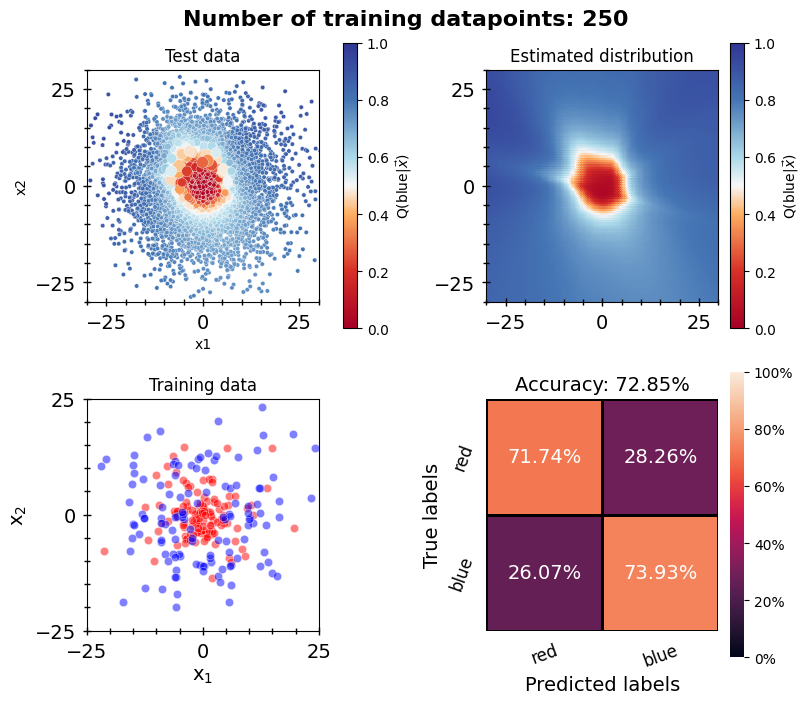

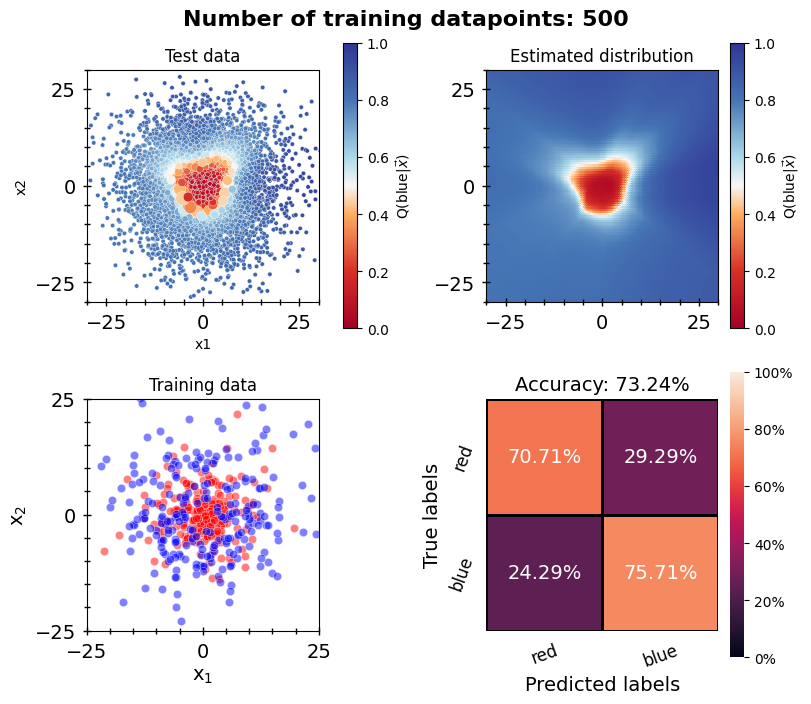

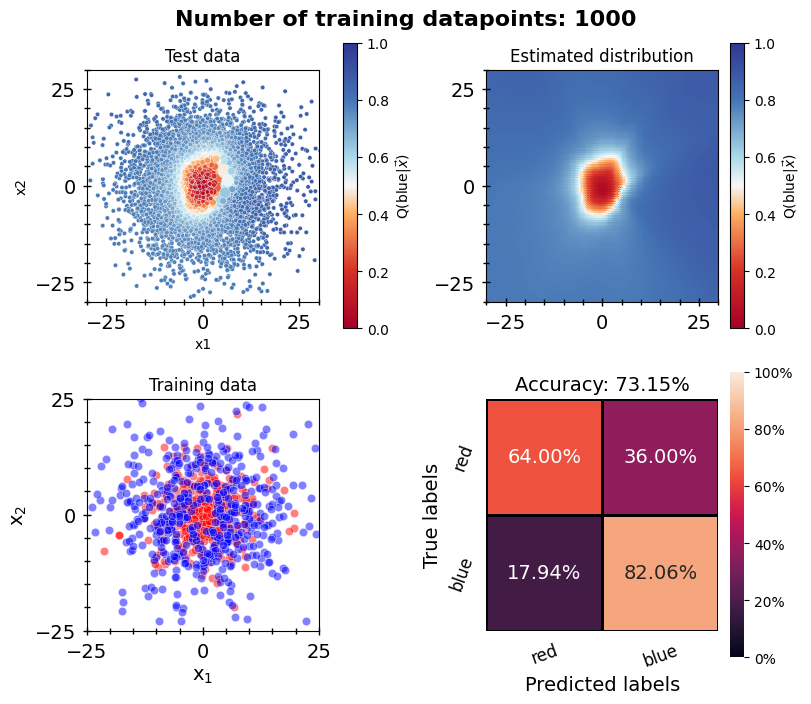

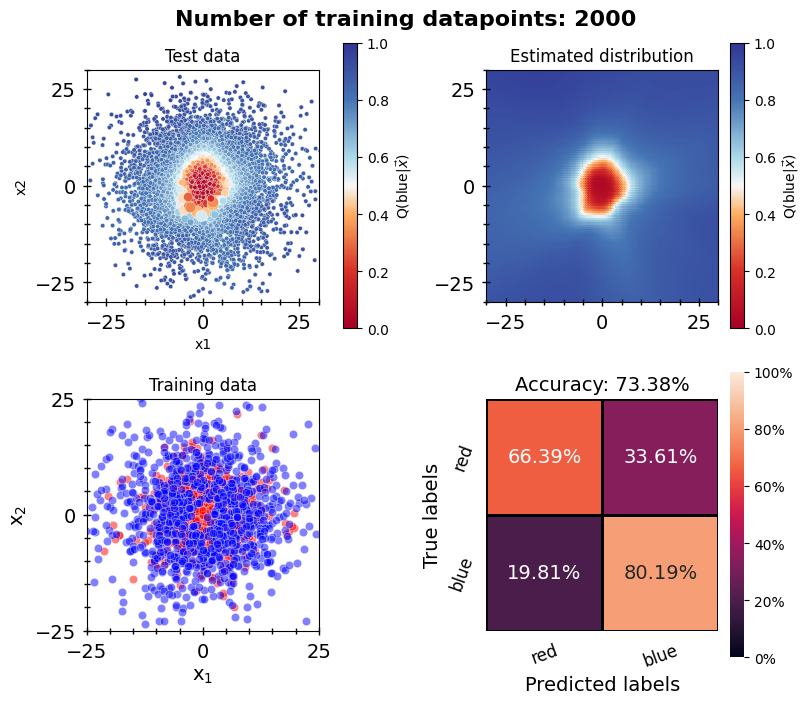

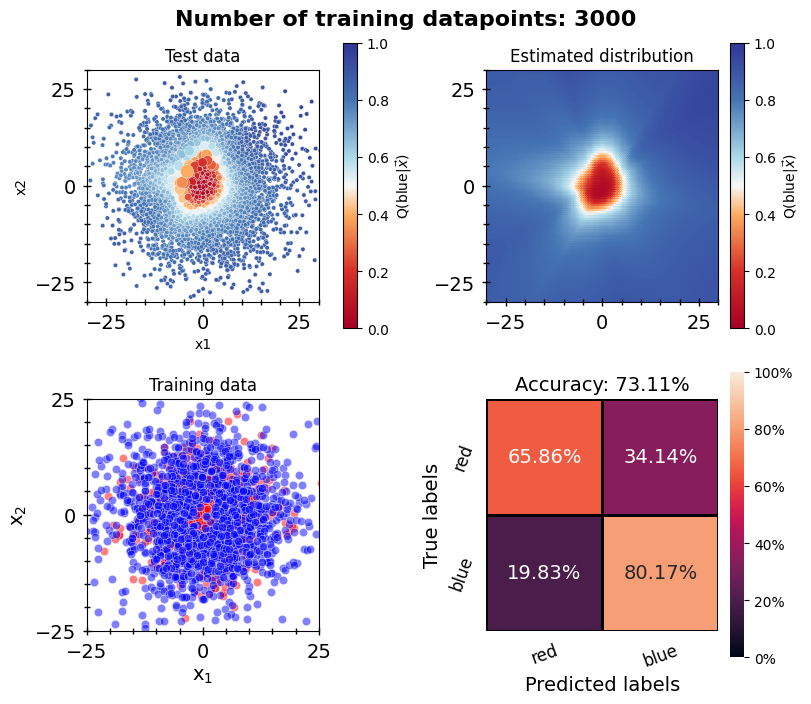

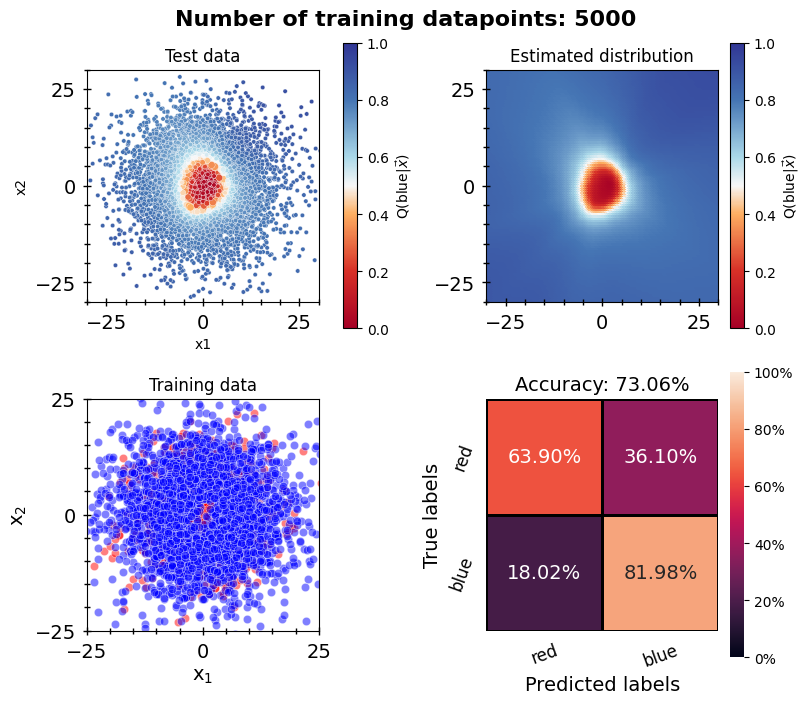

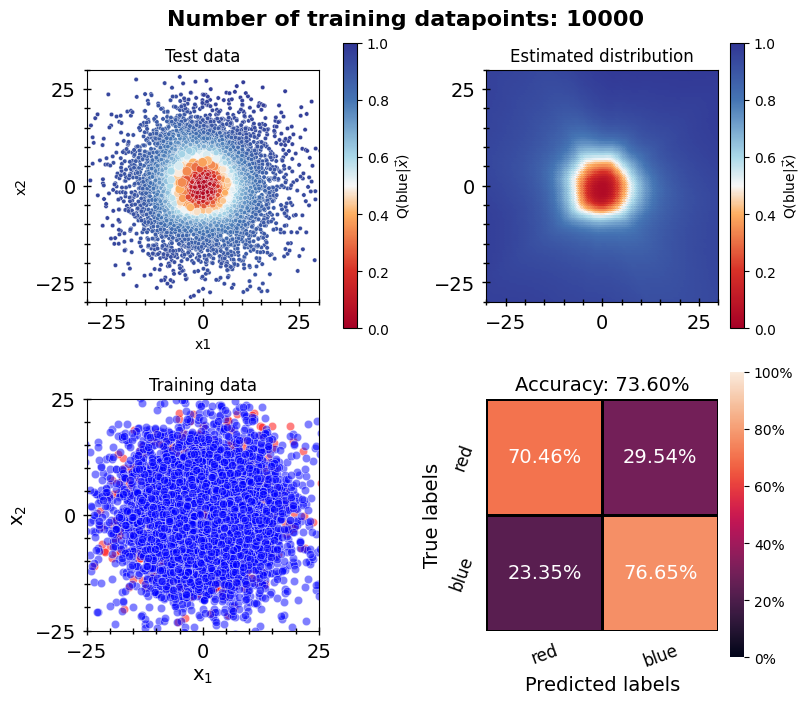

In [24]:
for i in range(len(n_data)):
    # Plot
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs[i], "Est_prob_blue", axs[0][0], "Test data", error_key="Std_prob_blue", rmax=grid_rmax)
    axs[0][1] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
    axs[1][1] = plot_conf_matrix(test_dfs[i], "class", "Prediction", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")


    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")


<Axes: xlabel='r', ylabel='Count'>

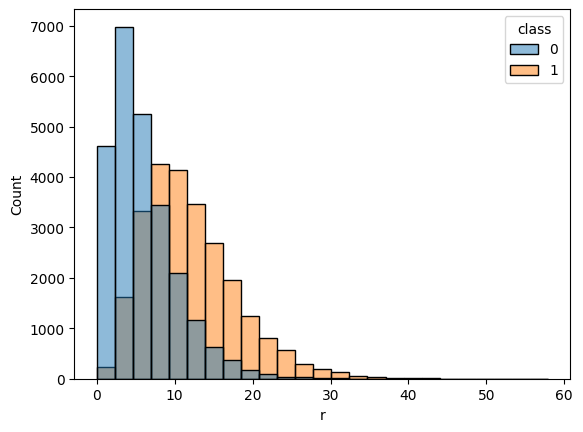

In [ ]:
sn.histplot(train_data, x="r", hue="class", bins=25)
#plt.xlim(25, 30)
#plt.ylim(0, 30)

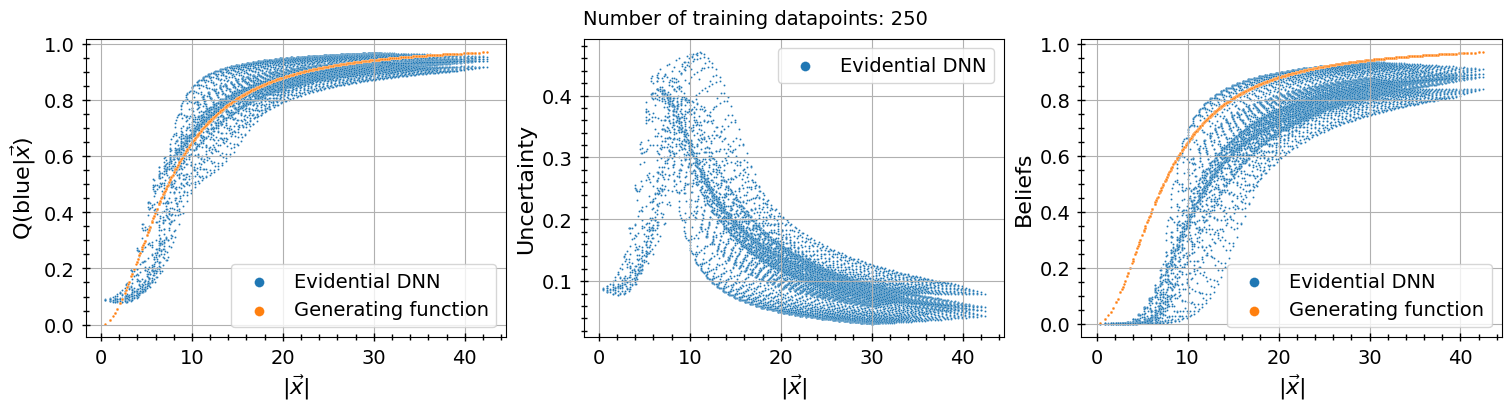

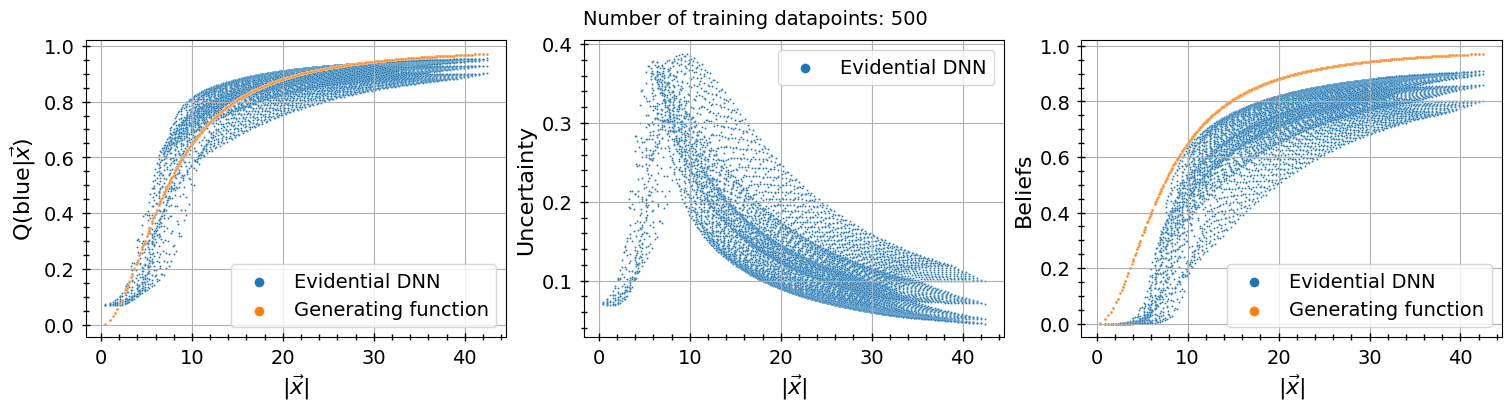

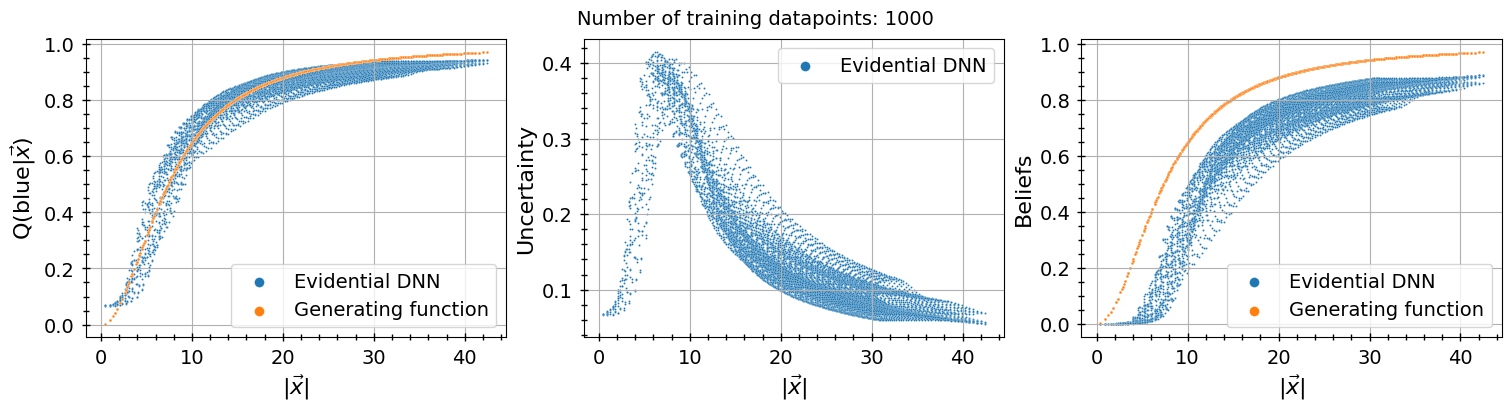

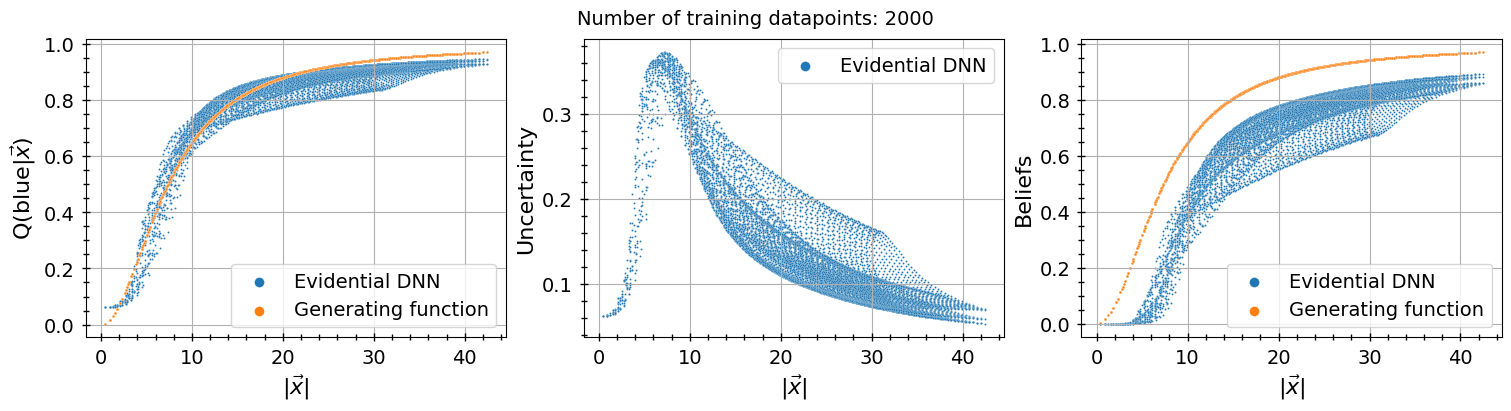

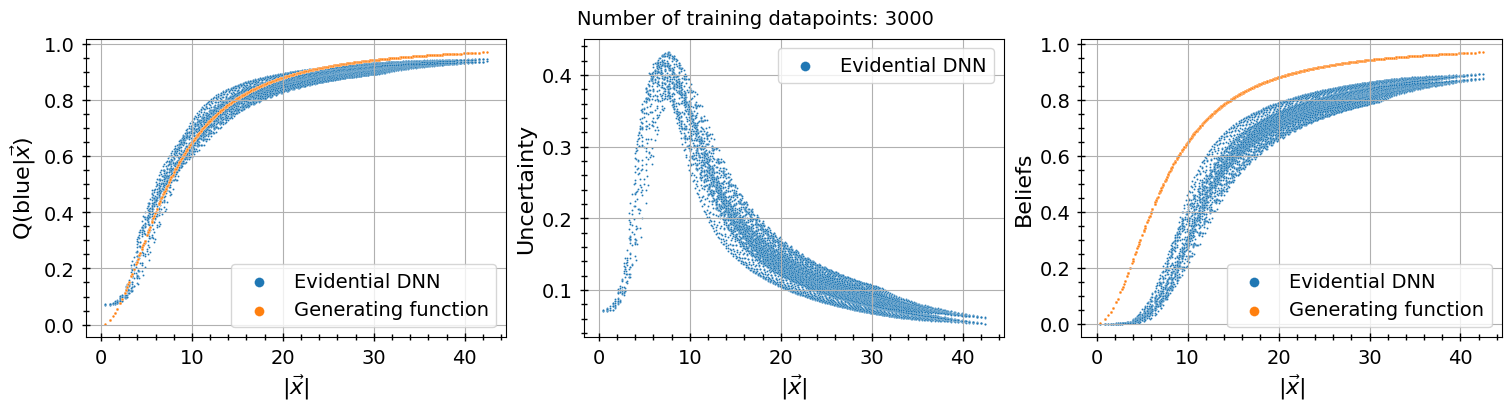

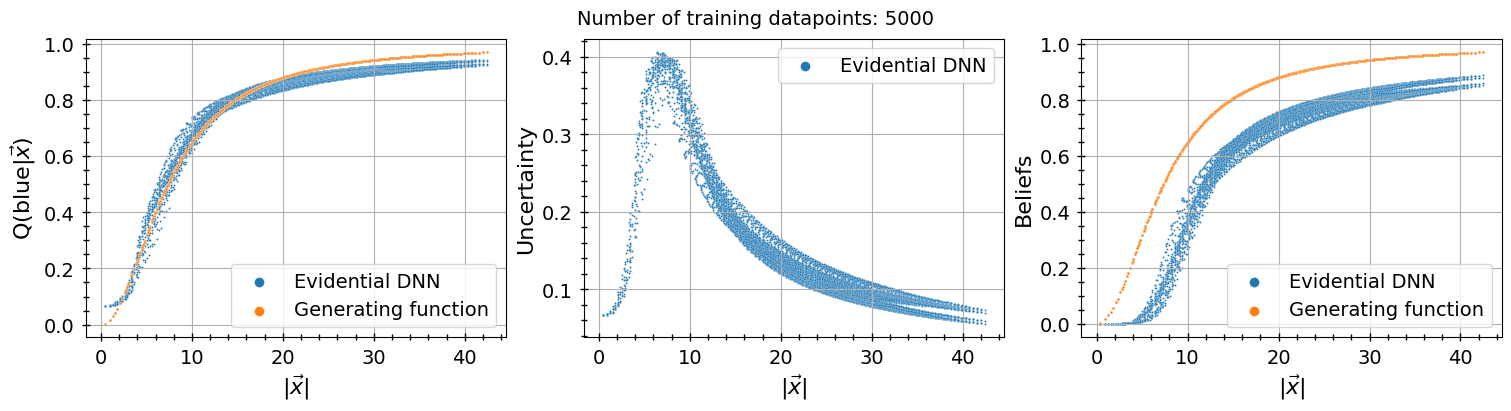

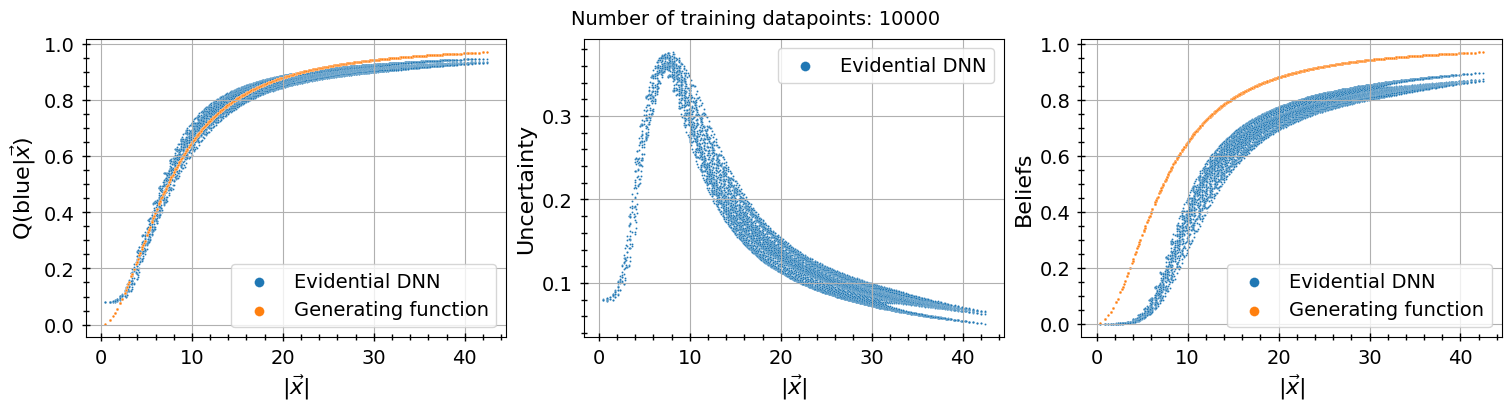

In [ ]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize= (5*3, 4), layout="constrained")

    sn.scatterplot(grid_dfs[i], x="r", y="Est_prob_blue", s=2, ax = axs[0], label ="Evidential DNN")
    sn.scatterplot(grid_dfs[i], x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r", y="Std_prob_blue", s=2, ax = axs[1], label ="Evidential DNN")
    axs[1].set_ylabel(r"Uncertainty", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r", y="Beliefs", s=2, ax = axs[2], label ="Evidential DNN")
    sn.scatterplot(grid_dfs[i], x="r", y="p_c1_given_r", s=2, ax = axs[2], label="Generating function")
    axs[2].set_ylabel(r"Beliefs", fontsize=16)

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.legend(markerscale=5, fontsize=14)

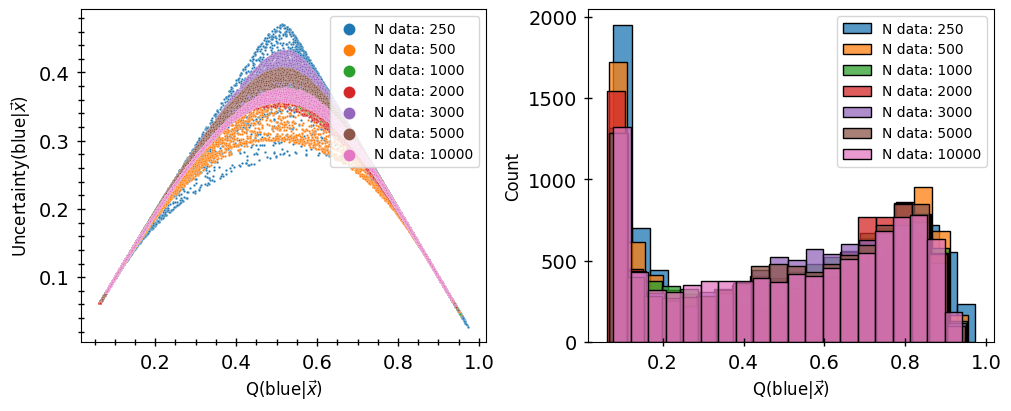

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="Est_prob_blue", y="Std_prob_blue", s=3, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=10, loc="upper right")
    axs[0].set_ylabel(r"Uncertainty(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    #axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs[i], x="Est_prob_blue", label=f"N data: {n_data[i]}", ax = axs[1], bins=20, edgecolor="black", linewidth=1)
    axs[1].legend(markerscale=5, fontsize=10, loc="upper right")
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

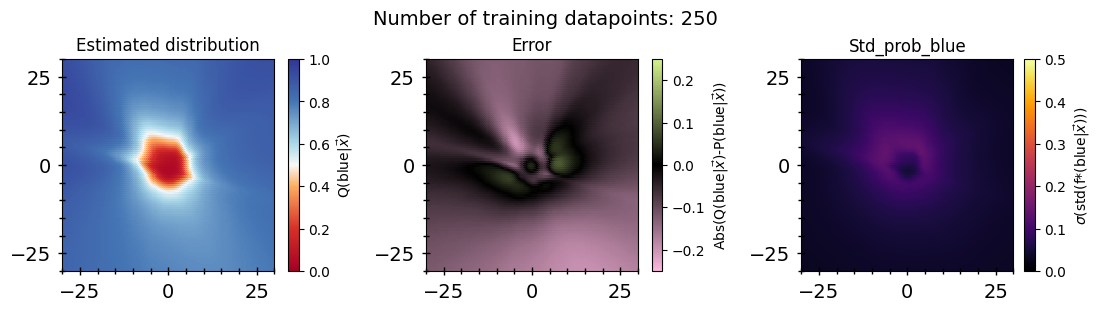

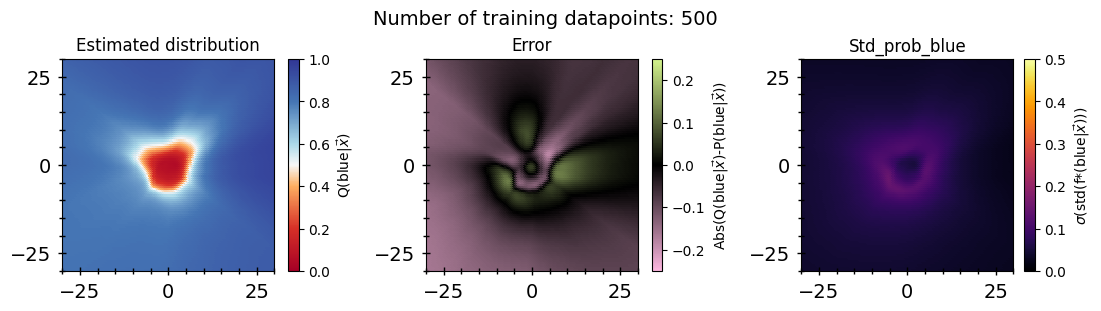

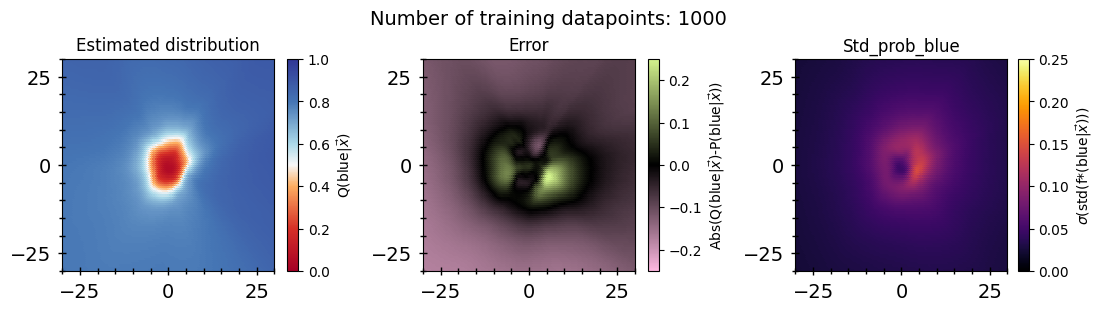

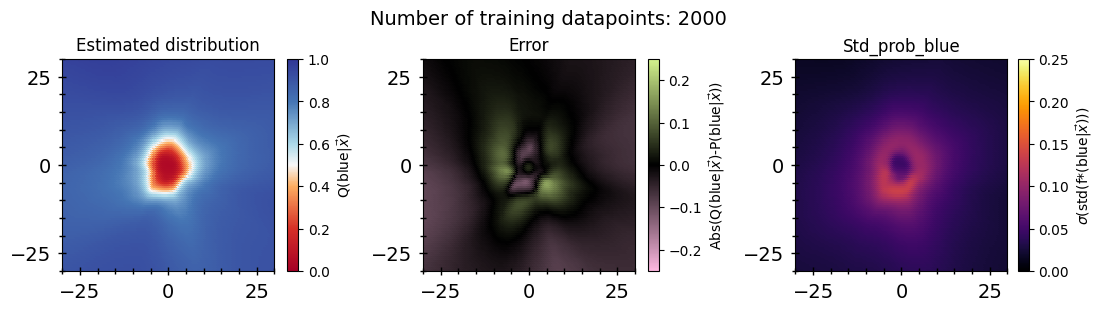

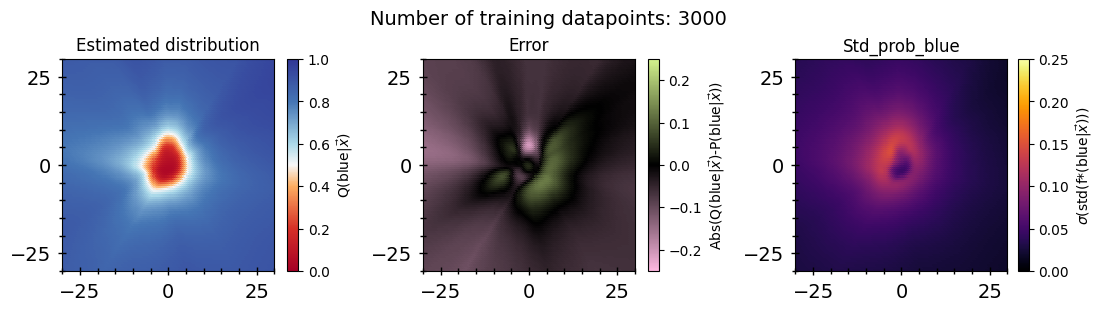

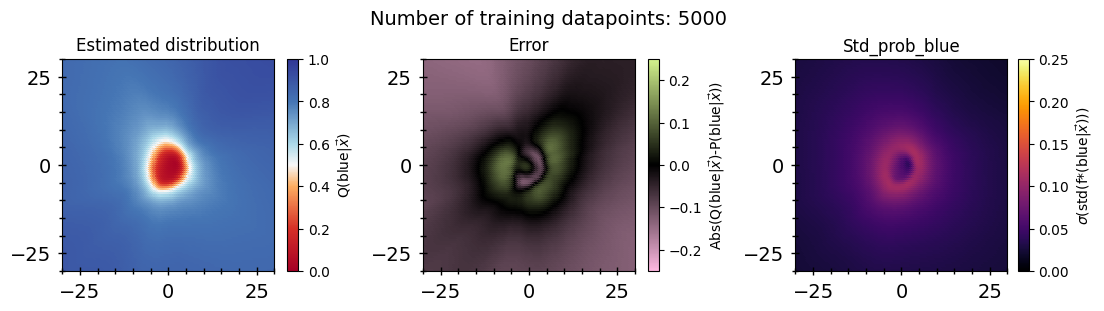

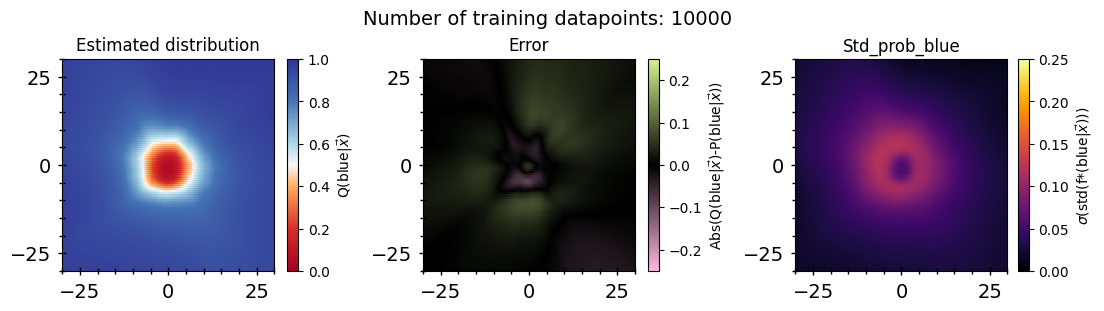

In [29]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

    axs[0] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], grid_dfs[0], "Est_prob_blue", "p_c1_given_r", axs[1], r"Error", max_val=0.25, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-0.25, vmax=0.25, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_std(grid_dfs[i], "Std_prob_blue", axs[2], "Std_prob_blue", grid=True, max_val=max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                    label=r"$\sigma$(std(f*(blue|$\vec{x}$)))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)


ValueError: y_prob has values outside [0, 1].

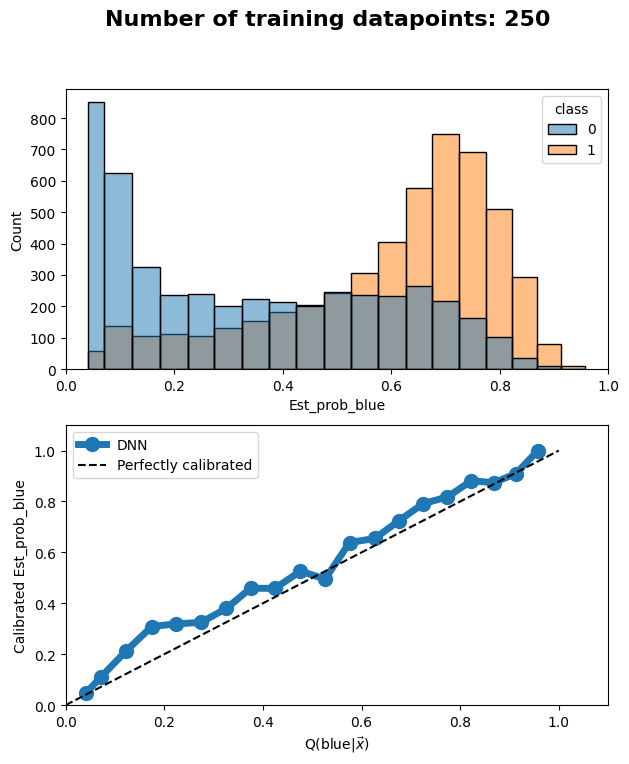

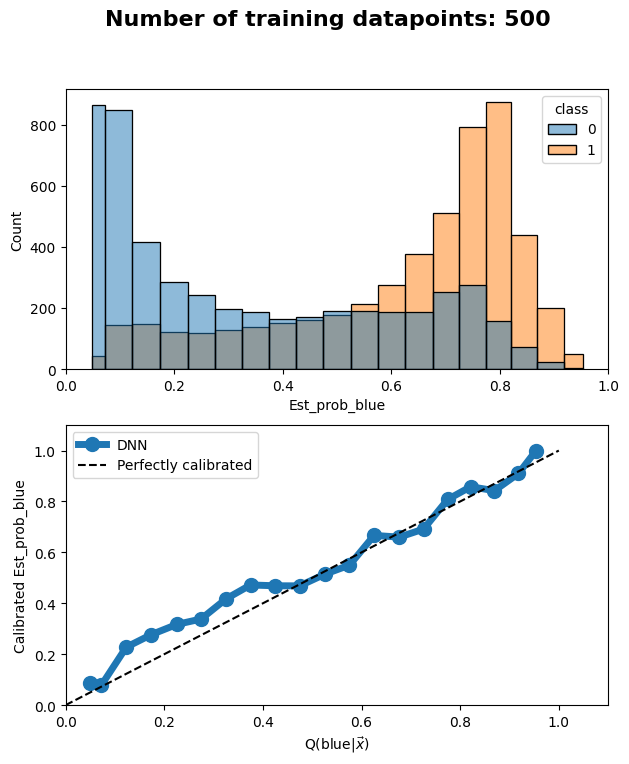

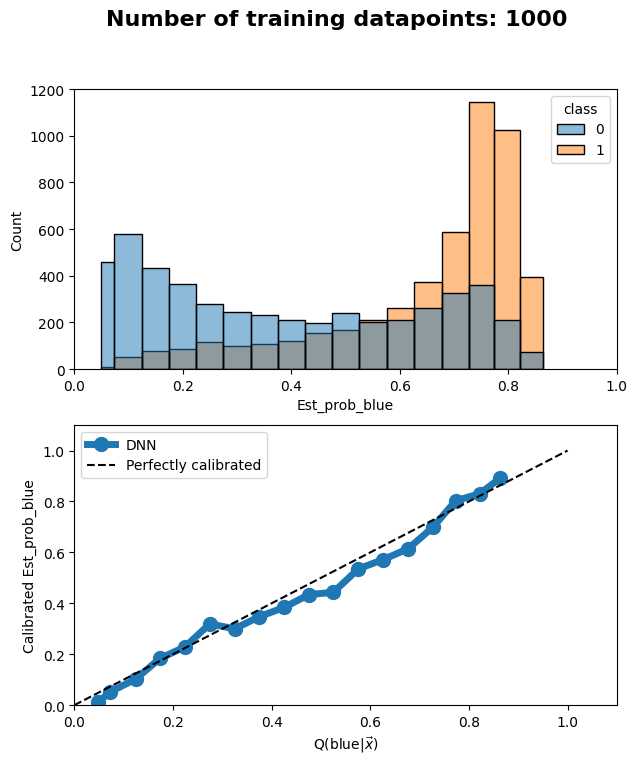

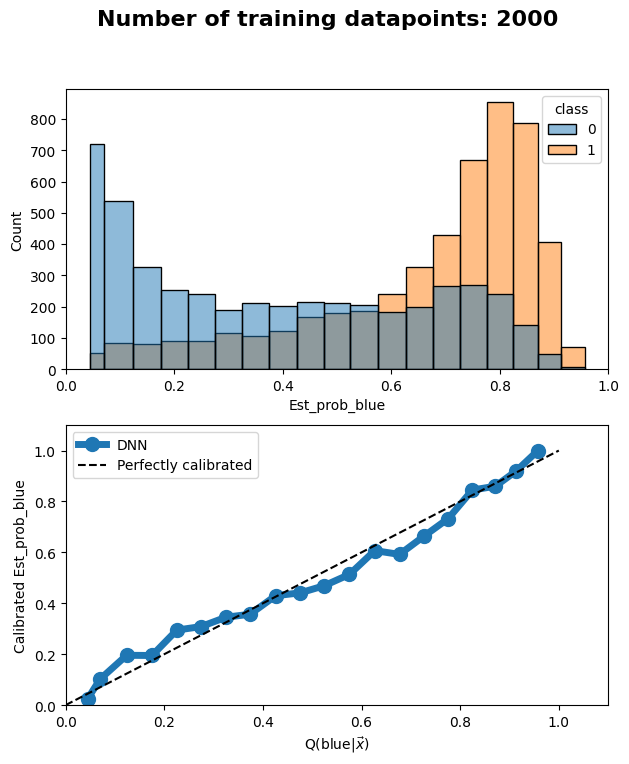

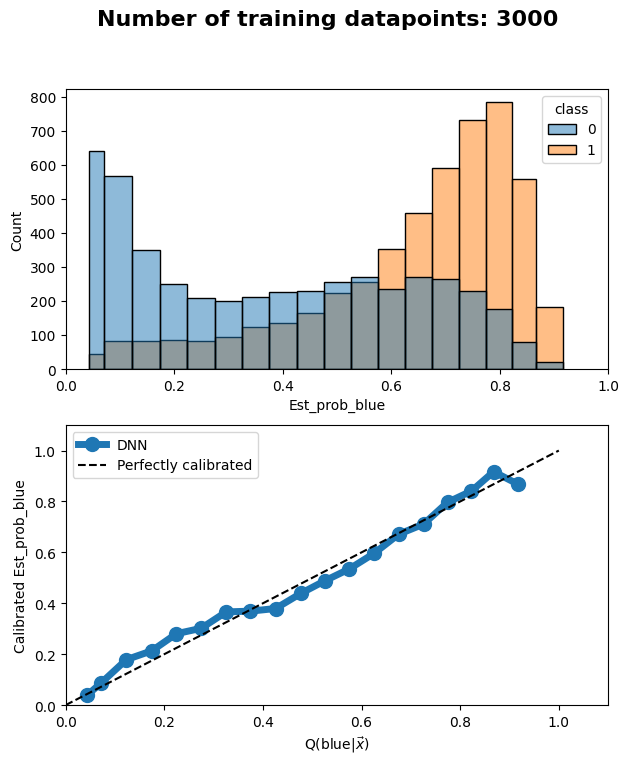

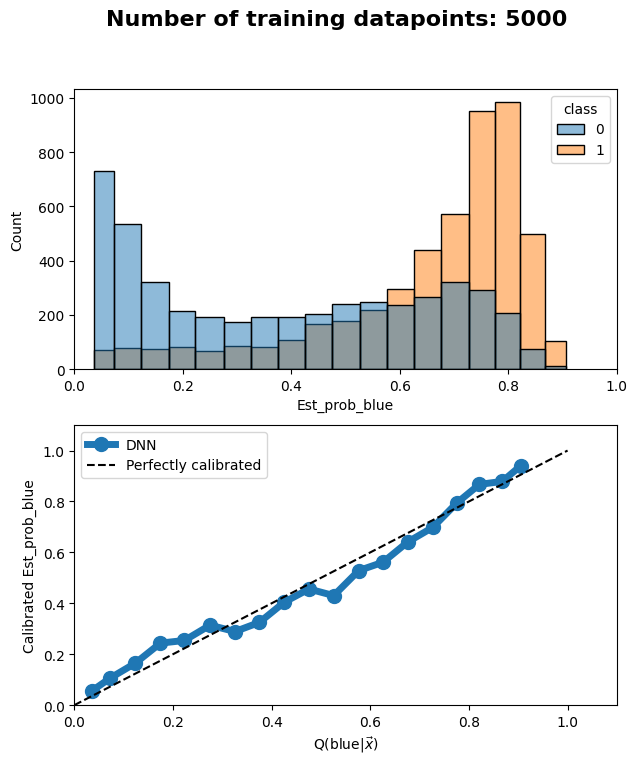

In [26]:
for i in range(len(n_data)):

    prob_cal, prob_pred = calibration_curve(test_dfs[i]["class"], test_dfs[i]["Est_prob_blue"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
    sn.histplot(test_dfs[i], x="Est_prob_blue", hue="class", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    ax[1].set_ylabel("Calibrated Est_prob_blue")
    ax[1].legend()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")